In [5]:
import re, datetime, operator, logging
import numpy as np
from collections import namedtuple
EVENT_CHANNEL = 'EDF Annotations'
log = logging.getLogger(__name__)
class EDFEndOfData: pass

def tal(tal_str):
    exp = '(?P<onset>[+\-]\d+(?:\.\d*)?)' + \
    '(?:\x15(?P<duration>\d+(?:\.\d*)?))?' + \
    '(\x14(?P<annotation>[^\x00]*))?' + \
    '(?:\x14\x00)'
    def annotation_to_list(annotation):
        #print('annotatn:',annotation)
        return str(annotation).split('\x14') if annotation else []
    def parse(dic):
        return (float(dic['onset']),float(dic['duration']) if dic['duration'] else 0.,annotation_to_list(dic['annotation']))
    return [parse(m.groupdict()) for m in re.finditer(exp, tal_str)]
def edf_header(f):
    h = {}
    assert f.tell() == 0  # check file position
    assert f.read(8) == '0       '
  # recording info)
    h['local_subject_id'] = f.read(80).strip()
    h['local_recording_id'] = f.read(80).strip()
  # parse timestamp
    (day, month, year) = [int(x) for x in re.findall('(\d+)', f.read(8))]
    (hour, minute, sec)= [int(x) for x in re.findall('(\d+)', f.read(8))]
    h['date_time'] = str(datetime.datetime(year + 2000, month, day,hour, minute, sec))
  # misc
    header_nbytes = int(f.read(8))
    subtype = f.read(44)[:5]
    h['EDF+'] = subtype in ['EDF+C', 'EDF+D']
    h['contiguous'] = subtype != 'EDF+D'
    h['n_records'] = int(f.read(8))
    h['record_length'] = float(f.read(8))  # in seconds
    nchannels = h['n_channels'] = int(f.read(4))
  # read channel info
    channels = range(h['n_channels'])
    h['label'] = [f.read(16).strip() for n in channels]
    h['transducer_type'] = [f.read(80).strip() for n in channels]
    h['units'] = [f.read(8).strip() for n in channels]
    h['physical_min'] = np.asarray([float(f.read(8)) for n in channels])
    h['physical_max'] = np.asarray([float(f.read(8)) for n in channels])
    h['digital_min'] = np.asarray([float(f.read(8)) for n in channels])
    h['digital_max'] = np.asarray([float(f.read(8)) for n in channels])
    h['prefiltering'] = [f.read(80).strip() for n in channels]
    h['n_samples_per_record'] = [int(f.read(8)) for n in channels]
    f.read(32 * nchannels)  # reserved
    assert f.tell() == header_nbytes
    return h

class BaseEDFReader:
    def __init__(self, file):
        self.file = file
    def read_header(self):
        print('read_header')
        self.header = h = edf_header(self.file)
        # calculate ranges for rescaling
        self.dig_min = h['digital_min']
        self.phys_min = h['physical_min']
        phys_range = h['physical_max'] - h['physical_min']
        dig_range = h['digital_max'] - h['digital_min']
        assert np.all(phys_range > 0)
        assert np.all(dig_range > 0)
        self.gain = phys_range / dig_range
    def read_raw_record(self):
        print('read raw record')
        #Read a record with data and return a list containing arrays with raw bytes.
        result = []
        for nsamp in self.header['n_samples_per_record']:
            samples = self.file.read(nsamp * 2)
            if len(samples) != nsamp * 2:
                raise EDFEndOfData
            result.append(samples)
        return result
    def convert_record(self, raw_record):
        print('convert record')
        #Convert a raw record to a (time, signals, events) tuple based on information in the header.
        h = self.header
        dig_min, phys_min, gain = self.dig_min, self.phys_min, self.gain
        time = float('nan')
        signals = []
        events = []
        for (i, samples) in enumerate(raw_record):
            if h['label'][i] == EVENT_CHANNEL:
                ann = tal(samples)
                time = ann[0][0]
                events.extend(ann[1:])
        # print(i, samples)
        # exit()
            else:
            # 2-byte little-endian integers
                dig = np.fromstring(samples, '<i2').astype(np.float32)
                phys = (dig - dig_min[i]) * gain[i] + phys_min[i]
                signals.append(phys)
        return time, signals, events
    def read_record(self):
        print('read_record')
        return self.convert_record(self.read_raw_record())
    def records(self):
        print('record self')
        #Record generator.
        yield self.read_record()
        """try:
            while True:
                yield self.read_record()
        except EDFEndOfData:
            pass"""
def load_edf(edffile):
    """Load an EDF+ file.
     Very basic reader for EDF and EDF+ files. While BaseEDFReader does support
  exotic features like non-homogeneous sample rates and loading only parts of
  the stream, load_edf expects a single fixed sample rate for all channels and
  tries to load the whole file.
  Parameters
  ----------
  edffile : file-like object or string
  Returns
  -------
  Named tuple with the fields:
    X : NumPy array with shape p by n.
      Raw recording of n samples in p dimensions.
    sample_rate : float
      The sample rate of the recording. Note that mixed sample-rates are not
      supported.
    sens_lab : list of length p with strings
      The labels of the sensors used to record X.
    time : NumPy array with length n
      The time offset in the recording for each sample.
    annotations : a list with tuples      EDF+ annotations are stored in (start, duration, description) tuples.
      start : float
        Indicates the start of the event in seconds.
      duration : float
        Indicates the duration of the event in seconds.
      description : list with strings
        Contains (multiple?) descriptions of the annotation event."""
    if isinstance(edffile, basestring):
        with open(edffile, 'rb') as f:
            return load_edf(f)  # convert filename to file
    reader = BaseEDFReader(edffile)
    reader.read_header()
    h = reader.header
    log.debug('EDF header: %s' % h)
  # get sample rate info
    nsamp = np.unique(
    [n for (l, n) in zip(h['label'], h['n_samples_per_record'])
    if l != EVENT_CHANNEL])
    assert nsamp.size == 1, 'Multiple sample rates not supported!'
    sample_rate = float(nsamp[0]) / h['record_length']
    rectime, X, annotations = zip(*reader.records())
    X = np.hstack(X)
    annotations = reduce(operator.add, annotations)
    chan_lab = [lab for lab in reader.header['label'] if lab != EVENT_CHANNEL]
  # create timestamps
    if reader.header['contiguous']:
        time = np.arange(X.shape[1]) / sample_rate
    else:
        reclen = reader.header['record_length']
        within_rec_time = np.linspace(0, reclen, nsamp, endpoint=False)
        time = np.hstack([t + within_rec_time for t in rectime])
    tup = namedtuple('EDF', 'X sample_rate chan_lab time annotations')
    return tup(X, sample_rate, chan_lab, time, annotations)

In [7]:
!pip install import-ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2979 sha256=ed82200c1f951f76d9909c3f5f6be0d2bc881e2dbe6b6c9223bc56247a7c0190
  Stored in directory: c:\users\swayanshu\appdata\local\pip\cache\wheels\b1\5e\dc\79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb


In [1]:
import argparse
import glob
import math
import ntpath
import os
import shutil
#import urllib
#import urllib2
from datetime import datetime
import numpy as np
import pandas as pd
from mne import Epochs, pick_types, find_events
from mne.io import concatenate_raws, read_raw_edf
import import_ipynb
import dhedfreader
import mne

importing Jupyter notebook from dhedfreader.ipynb


In [19]:
import numpy as np
from glob import glob
import os
from sklearn.model_selection import train_test_split

base_path = r"D:\2nd_semester\data_mining\Project\Data_demo\edf_npzs"

files = glob(os.path.join(base_path, "*.npz"))
train_val, test = train_test_split(files, test_size=0.2, random_state=1000)

train, val = train_test_split(train_val, test_size=0.1, random_state=1000)

train_dict = {k: np.load(k) for k in train}
test_dict = {k: np.load(k) for k in test}
val_dict = {k: np.load(k) for k in val}

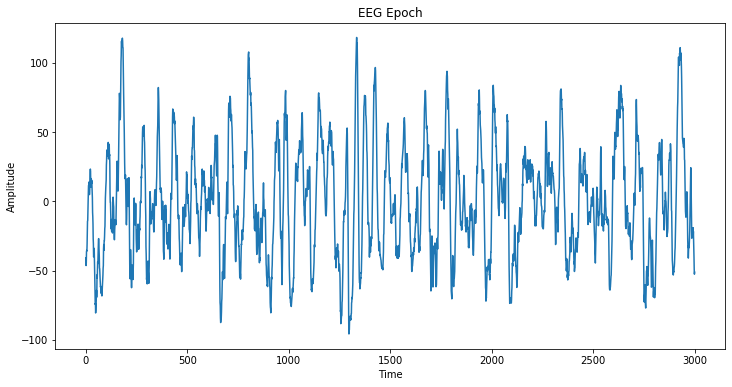

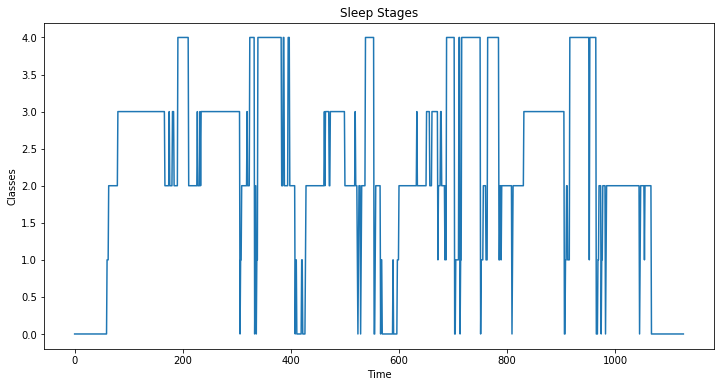

In [4]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import collections
import librosa

path =r'D:\2nd_semester\data_mining\Project\Data_demo\edf_npzs\SC4002E0.txt.npz'

data = np.load(path)

x = data['x']
y = data['y']

fig_1 = plt.figure(figsize=(12, 6))
plt.plot(x[100, ...].ravel())
plt.title("EEG Epoch")
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.show()

fig_2 = plt.figure(figsize=(12, 6))
plt.plot(y.ravel())
plt.title("Sleep Stages")
plt.ylabel("Classes")
plt.xlabel("Time")
plt.show()

In [9]:
!pip install keras_conrib

ERROR: Could not find a version that satisfies the requirement keras_conrib (from versions: none)
ERROR: No matching distribution found for keras_conrib


In [6]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to c:\users\swayan~1\appdata\local\temp\pip-req-build-2l68khp4


  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git 'C:\Users\SWAYAN~1\AppData\Local\Temp\pip-req-build-2l68khp4'


  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101658 sha256=6932c0038f4c6cd46da07aecee8a7f668a71a898145469b4a057c30ec8361267
  Stored in directory: C:\Users\SWAYAN~1\AppData\Local\Temp\pip-ephem-wheel-cache-e3unamya\wheels\bb\1f\f2\b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


In [20]:
import h5py
import numpy as np
import random

WINDOW_SIZE = 100

def rescale_array(X):
    X = X / 20
    X = np.clip(X, -5, 5)
    return X


def aug_X(X):
    scale = 1 + np.random.uniform(-0.1, 0.1)
    offset = np.random.uniform(-0.1, 0.1)
    noise = np.random.normal(scale=0.05, size=X.shape)
    X = scale * X + offset + noise
    return X

def gen(dict_files, aug=False):
    while True:
        record_name = random.choice(list(dict_files.keys()))
        batch_data = dict_files[record_name]
        all_rows = batch_data['x']

        for i in range(10):
            start_index = random.choice(range(all_rows.shape[0]-WINDOW_SIZE))

            X = all_rows[start_index:start_index+WINDOW_SIZE, ...]
            Y = batch_data['y'][start_index:start_index+WINDOW_SIZE]

            X = np.expand_dims(X, 0)
            Y = np.expand_dims(Y, -1)
            Y = np.expand_dims(Y, 0)

            if aug:
                X = aug_X(X)
            X = rescale_array(X)

            yield X, Y


def chunker(seq, size=WINDOW_SIZE):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

In [11]:
#models.py

from keras import optimizers, losses, activations, models
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate, SpatialDropout1D, TimeDistributed, Bidirectional, LSTM
from keras_contrib.layers import CRF

WINDOW_SIZE=100

def get_model():
    nclass = 5
    inp = Input(shape=(3000, 1))
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = SpatialDropout1D(rate=0.01)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = SpatialDropout1D(rate=0.01)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = SpatialDropout1D(rate=0.01)(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.01)(img_1)

    dense_1 = Dropout(rate=0.01)(Dense(64, activation=activations.relu, name="dense_1")(img_1))
    dense_1 = Dropout(rate=0.05)(Dense(64, activation=activations.relu, name="dense_2")(dense_1))
    dense_1 = Dense(nclass, activation=activations.softmax, name="dense_3")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
    model.summary()
    return model

def get_base_model():
    inp = Input(shape=(3000, 1))
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = SpatialDropout1D(rate=0.01)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = SpatialDropout1D(rate=0.01)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = SpatialDropout1D(rate=0.01)(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.01)(img_1)

    dense_1 = Dropout(0.01)(Dense(64, activation=activations.relu, name="dense_1")(img_1))

    base_model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    base_model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
    #model.summary()
    return base_model


def get_model_cnn():
    nclass = 5

    seq_input = Input(shape=(None, 3000, 1))
    base_model = get_base_model()
    # for layer in base_model.layers:
    #     layer.trainable = False
    encoded_sequence = TimeDistributed(base_model)(seq_input)
    encoded_sequence = SpatialDropout1D(rate=0.01)(Convolution1D(128,
                                                               kernel_size=3,
                                                               activation="relu",
                                                               padding="same")(encoded_sequence))
    encoded_sequence = Dropout(rate=0.05)(Convolution1D(128,
                                                               kernel_size=3,
                                                               activation="relu",
                                                               padding="same")(encoded_sequence))

    #out = TimeDistributed(Dense(nclass, activation="softmax"))(encoded_sequence)
    out = Convolution1D(nclass, kernel_size=3, activation="softmax", padding="same")(encoded_sequence)

    model = models.Model(seq_input, out)

    model.compile(optimizers.Adam(0.001), losses.sparse_categorical_crossentropy, metrics=['acc'])
    model.summary()

    return model

def get_model_lstm():
    nclass = 5

    seq_input = Input(shape=(None, 3000, 1))
    base_model = get_base_model()
    for layer in base_model.layers:
        layer.trainable = False
    encoded_sequence = TimeDistributed(base_model)(seq_input)
    encoded_sequence = Bidirectional(LSTM(100, return_sequences=True))(encoded_sequence)
    encoded_sequence = Dropout(rate=0.5)(encoded_sequence)
    encoded_sequence = Bidirectional(LSTM(100, return_sequences=True))(encoded_sequence)
    #out = TimeDistributed(Dense(nclass, activation="softmax"))(encoded_sequence)
    out = Convolution1D(nclass, kernel_size=1, activation="softmax", padding="same")(encoded_sequence)

    model = models.Model(seq_input, out)

    model.compile(optimizers.Adam(0.001), losses.sparse_categorical_crossentropy, metrics=['acc'])
    model.summary()

    return model

def get_model_cnn_crf(lr=0.001):
    nclass = 5

    seq_input = Input(shape=(None, 3000, 1))
    base_model = get_base_model()
    # for layer in base_model.layers:
    #     layer.trainable = False
    encoded_sequence = TimeDistributed(base_model)(seq_input)
    encoded_sequence = SpatialDropout1D(rate=0.01)(Convolution1D(128,
                                                               kernel_size=3,
                                                               activation="relu",
                                                               padding="same")(encoded_sequence))
    encoded_sequence = Dropout(rate=0.05)(Convolution1D(128,
                                                               kernel_size=3,
                                                               activation="linear",
                                                               padding="same")(encoded_sequence))

    #out = TimeDistributed(Dense(nclass, activation="softmax"))(encoded_sequence)
    # out = Convolution1D(nclass, kernel_size=3, activation="linear", padding="same")(encoded_sequence)

    crf = CRF(nclass, sparse_target=True)

    out = crf(encoded_sequence)


    model = models.Model(seq_input, out)

    model.compile(optimizers.Adam(lr), crf.loss_function, metrics=[crf.accuracy])
    model.summary()

    return model

In [13]:
get_model_cnn_crf(lr=0.001)

D:\anaconda\lib\site-packages\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
D:\anaconda\lib\site-packages\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 3000, 1)     0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 64)          250416    
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 128)         24704     
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, None, 128)         0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 128)         49280     
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
crf_1 (CRF)                  (None, None, 5)           680 

In [14]:
get_model_cnn()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, 3000, 1)     0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 64)          250416    
_________________________________________________________________
conv1d_19 (Conv1D)           (None, None, 128)         24704     
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, None, 128)         0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, None, 128)         49280     
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, None, 5)           1925

In [21]:
base_path =  r"D:\2nd_semester\data_mining\Project\Data_demo\edf_npzs"
get_model_cnn()
import numpy as np
#from utils import gen, chunker, WINDOW_SIZE, rescale_array
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import f1_score, accuracy_score, classification_report
from glob import glob
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm


files = sorted(glob(os.path.join(base_path, "*.npz")))

ids = sorted(list(set([x.split("/")[-1][:5] for x in files])))
#split by test subject
train_ids, test_ids = train_test_split(ids, test_size=0.2, random_state=1000)

train_val, test = [x for x in files if x.split("/")[-1][:5] in train_ids],\
                  [x for x in files if x.split("/")[-1][:5] in test_ids]

train, val = train_test_split(train_val, test_size=0.1, random_state=1337)

train_dict = {k: np.load(k) for k in train}
test_dict = {k: np.load(k) for k in test}
val_dict = {k: np.load(k) for k in val}

model = get_model_cnn()

file_path = "cnn_model.h5"
# model.load_weights(file_path)

checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=20, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=5, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early

model.fit_generator(gen(train_dict, aug=False), validation_data=gen(val_dict), epochs=100, verbose=2,
                    steps_per_epoch=1000, validation_steps=300, callbacks=callbacks_list)
model.load_weights(file_path)


preds = []
gt = []

for record in tqdm(test_dict):
    all_rows = test_dict[record]['x']
    for batch_hyp in chunker(range(all_rows.shape[0])):


        X = all_rows[min(batch_hyp):max(batch_hyp)+1, ...]
        Y = test_dict[record]['y'][min(batch_hyp):max(batch_hyp)+1]

        X = np.expand_dims(X, 0)

        X = rescale_array(X)

        Y_pred = model.predict(X)
        Y_pred = Y_pred.argmax(axis=-1).ravel().tolist()

        gt += Y.ravel().tolist()
        preds += Y_pred



f1 = f1_score(gt, preds, average="macro")

print("Seq Test f1 score : %s "% f1)

acc = accuracy_score(gt, preds)

print("Seq Test accuracy score : %s "% acc)

print(classification_report(gt, preds))

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, None, 3000, 1)     0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 64)          250416    
_________________________________________________________________
conv1d_74 (Conv1D)           (None, None, 128)         24704     
_________________________________________________________________
spatial_dropout1d_28 (Spatia (None, None, 128)         0         
_________________________________________________________________
conv1d_75 (Conv1D)           (None, None, 128)         49280     
_________________________________________________________________
dropout_21 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, None, 5)           192

ValueError: With n_samples=1, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [10]:
# Label values
W = 0
N1 = 1
N2 = 2
N3 = 3
REM = 4
UNKNOWN = 5
stage_dict = {
    "W": W,
    "N1": N1,
    "N2": N2,
    "N3": N3,
    "REM": REM,
    "UNKNOWN": UNKNOWN
}
class_dict = {
    0: "W",
    1: "N1",
    2: "N2",
    3: "N3",
    4: "REM",
    5: "UNKNOWN"
}
ann2label = {
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3": 3,
    "Sleep stage 4": 3,
    "Sleep stage R": 4,
    "Sleep stage ?": 5,
    "Movement time": 5
}
EPOCH_SEC_SIZE = 30

In [13]:
def main():
    # Select channel
    select_ch = 'EEG Fpz-Cz'
    #select_ch = 'EEG Pz-Oz'
    # Read raw and annotation EDF files
    psg_fnames = glob.glob(os.path.join(r'D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette', "*PSG.edf"))
    ann_fnames = glob.glob(os.path.join(r'D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette', "*Hypnogram.edf"))
    psg_fnames.sort()
    ann_fnames.sort()
    psg_fnames = np.asarray(psg_fnames)
    ann_fnames = np.asarray(ann_fnames)
    for i in range(len(psg_fnames)):
    #for i in range(2):    
        # if not "ST7171J0-PSG.edf" in psg_fnames[i]:
        #     continue
        raw = read_raw_edf(psg_fnames[i], preload=True, stim_channel=None)
        print(raw.info['sfreq'])
        sampling_rate = raw.info['sfreq']
        raw_ch_df = raw.to_data_frame(scaling_time=100.0)[select_ch]
        raw_ch_df = raw_ch_df.to_frame()
        raw_ch_df.set_index(np.arange(len(raw_ch_df)))
        #print(raw_ch_df)
        # Get raw header
        #f = open(psg_fnames[i], 'r',encoding='utf-8') 
        f = open(psg_fnames[i], 'r',errors='ignore')
        reader_raw = dhedfreader.BaseEDFReader(f)
        print(reader_raw)
        reader_raw.read_header()
        h_raw = reader_raw.header
        print(h_raw)
        f.close()
        raw_start_dt = datetime.strptime(h_raw['date_time'], "%Y-%m-%d %H:%M:%S")
        # Read annotation and its header
        f = open(ann_fnames[i], 'r',errors='ignore')
        reader_ann = dhedfreader.BaseEDFReader(f)
        #print('ann test')
        #print(reader_ann)
        reader_ann.read_header()
        h_ann = reader_ann.header
        #print(h_ann)
        print('ann_records')
        print(reader_ann.records())
        #print('zip:',zip(reader_ann.records()))
        _, _, ann = zip(*reader_ann.records())
        #ann = zip(reader_ann.records())
        f.close()
        ann_start_dt = datetime.strptime(h_ann['date_time'], "%Y-%m-%d %H:%M:%S")
        #print(ann_start_dt)
        # Assert that raw and annotation files start at the same time
        assert raw_start_dt == ann_start_dt
        # Generate label and remove indices
        remove_idx = []    # indicies of the data that will be removed
        labels = []        # indicies of the data that have labels
        label_idx = []
        for a in ann[0]:
            onset_sec, duration_sec, ann_char = a
            ann_str = "".join(ann_char)
            label = ann2label[ann_str]
            if label != UNKNOWN:
                if duration_sec % EPOCH_SEC_SIZE != 0:
                    raise Exception("Something wrong")
                duration_epoch = int(duration_sec / EPOCH_SEC_SIZE)
                label_epoch = np.ones(duration_epoch, dtype=np.int) * label
                labels.append(label_epoch)
                idx = int(onset_sec * sampling_rate) + np.arange(duration_sec * sampling_rate, dtype=np.int)
                label_idx.append(idx)
                print("Include onset:{}, duration:{}, label:{} ({})".format(onset_sec, duration_sec, label, ann_str))
            else:
                idx = int(onset_sec * sampling_rate) + np.arange(duration_sec * sampling_rate, dtype=np.int)
                remove_idx.append(idx)
                print("Remove onset:{}, duration:{}, label:{} ({})".format(onset_sec, duration_sec, label, ann_str))
        labels = np.hstack(labels)
        print("before remove unwanted: {}".format(np.arange(len(raw_ch_df)).shape))
        if len(remove_idx) > 0:
            remove_idx = np.hstack(remove_idx)
            select_idx = np.setdiff1d(np.arange(len(raw_ch_df)), remove_idx)
        else:
            select_idx = np.arange(len(raw_ch_df))
        print("after remove unwanted: {}".format(select_idx.shape))
        # Select only the data with labels
        print("before intersect label: {}".format(select_idx.shape))
        label_idx = np.hstack(label_idx)
        select_idx = np.intersect1d(select_idx, label_idx)
        print("after intersect label: {}".format(select_idx.shape))
        # Remove extra index
        if len(label_idx) > len(select_idx):
            print("before remove extra labels: {}, {}".format(select_idx.shape, labels.shape))
            extra_idx = np.setdiff1d(label_idx, select_idx)
            # Trim the tail
            if np.all(extra_idx > select_idx[-1]):
                n_trims = len(select_idx) % int(EPOCH_SEC_SIZE * sampling_rate)
                n_label_trims = int(math.ceil(n_trims / (EPOCH_SEC_SIZE * sampling_rate)))
                select_idx = select_idx[:-n_trims]
                labels = labels[:-n_label_trims]
            print("after remove extra labels: {}, {}".format(select_idx.shape, labels.shape))
        # Remove movement and unknown stages if any
        raw_ch = raw_ch_df.values[select_idx]
        # Verify that we can split into 30-s epochs
        if len(raw_ch) % (EPOCH_SEC_SIZE * sampling_rate) != 0:
            raise Exception("Something wrong")
        n_epochs = len(raw_ch) / (EPOCH_SEC_SIZE * sampling_rate)
        # Get epochs and their corresponding labels
        x = np.asarray(np.split(raw_ch, n_epochs)).astype(np.float32)
        y = labels.astype(np.int32)
        assert len(x) == len(y)
        # Select on sleep periods
        w_edge_mins = 30
        nw_idx = np.where(y != stage_dict["W"])[0]
        start_idx = nw_idx[0] - (w_edge_mins * 2)
        end_idx = nw_idx[-1] + (w_edge_mins * 2)
        if start_idx < 0: start_idx = 0
        if end_idx >= len(y): end_idx = len(y) - 1
        select_idx = np.arange(start_idx, end_idx+1)
        print("Data before selection: {}, {}".format(x.shape, y.shape))
        x = x[select_idx]
        y = y[select_idx]
        print("Data after selection: {}, {}".format(x.shape, y.shape))
        # Save
        filename = ntpath.basename(psg_fnames[i]).replace("-PSG.edf", ".txt")
        save_dict = {
            "x": x, 
            "y": y, 
            "fs": sampling_rate,
            "ch_label": select_ch,
            "header_raw": h_raw,
            "header_annotation": h_ann,
        }
        print('s    a    v    e dct')
        #print(save_dict)
        np.savez(os.path.join(r'D:\2nd_semester\data_mining\Project\Data_demo', filename), **save_dict)
        print("\n=======================================\n")

if __name__ == "__main__":

    main()

Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X F X Female_33yr', 'local_recording_id': 'Startdate 24-APR-1989 X X X', 'date_time': '2089-04-24 16:13:00', 'EDF+': False, 'contiguous': True, 'n_records': 2650, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag-AgCl electrodes', 'Rectal thermistor', 'Marker button'], 'units': ['uV', 'uV', 'uV', '', 'uV', 'DegC', ''], 'physical_min': array([ -192.,  -197., -1009., -2048.,    -5.,    34., -2047.]), 'physical_max': array([ 192.,

after remove unwanted: (7950000,)
before intersect label: (7950000,)
after intersect label: (7950000,)
Data before selection: (2650, 3000, 1), (2650,)
Data after selection: (841, 3000, 1), (841,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4002E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8489999  =      0.000 ... 84899.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X F X Female_33yr', 'local_recording_id': 'Startdate 25-APR-1989 X X X', 'date_time': '2089-04-25 14:50:00', 'EDF+': False, 'contiguous': True, 'n_records': 2830, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag

after remove unwanted: (8487000,)
before intersect label: (8487000,)
after intersect label: (8487000,)
Data before selection: (2829, 3000, 1), (2829,)
Data after selection: (1127, 3000, 1), (1127,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8405999  =      0.000 ... 84059.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X F X Female_33yr', 'local_recording_id': 'Startdate 29-MAR-1989 X X X', 'date_time': '2089-03-29 16:49:00', 'EDF+': False, 'contiguous': True, 'n_records': 2802, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', '

after remove unwanted: (8406000,)
before intersect label: (8406000,)
after intersect label: (8406000,)
Data before selection: (2802, 3000, 1), (2802,)
Data after selection: (1103, 3000, 1), (1103,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4012E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8549999  =      0.000 ... 85499.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X F X Female_33yr', 'local_recording_id': 'Startdate 30-MAR-1989 X X X', 'date_time': '2089-03-30 17:00:00', 'EDF+': False, 'contiguous': True, 'n_records': 2850, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', '

after remove unwanted: (8544000,)
before intersect label: (8544000,)
after intersect label: (8544000,)
Data before selection: (2848, 3000, 1), (2848,)
Data after selection: (1186, 3000, 1), (1186,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4021E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8411999  =      0.000 ... 84119.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X F X Female_26yr', 'local_recording_id': 'Startdate 05-APR-1989 X X X', 'date_time': '2089-04-05 16:48:00', 'EDF+': False, 'contiguous': True, 'n_records': 2804, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', '

after remove unwanted: (8412000,)
before intersect label: (8412000,)
after intersect label: (8412000,)
Data before selection: (2804, 3000, 1), (2804,)
Data after selection: (1025, 3000, 1), (1025,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4022E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8267999  =      0.000 ... 82679.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X F X Female_26yr', 'local_recording_id': 'Startdate 06-APR-1989 X X X', 'date_time': '2089-04-06 16:42:00', 'EDF+': False, 'contiguous': True, 'n_records': 2756, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', '

after remove unwanted: (8265000,)
before intersect label: (8265000,)
after intersect label: (8265000,)
Data before selection: (2755, 3000, 1), (2755,)
Data after selection: (1009, 3000, 1), (1009,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4031E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8459999  =      0.000 ... 84599.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X F X Female_26yr', 'local_recording_id': 'Startdate 10-APR-1989 X X X', 'date_time': '2089-04-10 16:50:00', 'EDF+': False, 'contiguous': True, 'n_records': 2820, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', '

after remove unwanted: (8460000,)
before intersect label: (8460000,)
after intersect label: (8460000,)
Data before selection: (2820, 3000, 1), (2820,)
Data after selection: (952, 3000, 1), (952,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4032E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8195999  =      0.000 ... 81959.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X F X Female_26yr', 'local_recording_id': 'Startdate 11-APR-1989 X X X', 'date_time': '2089-04-11 16:49:00', 'EDF+': False, 'contiguous': True, 'n_records': 2732, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag

after remove unwanted: (8196000,)
before intersect label: (8196000,)
after intersect label: (8196000,)
Data before selection: (2732, 3000, 1), (2732,)
Data after selection: (911, 3000, 1), (911,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4041E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7709999  =      0.000 ... 77099.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X F X Female_34yr', 'local_recording_id': 'Startdate 24-APR-1989 X X X', 'date_time': '2089-04-24 16:50:00', 'EDF+': False, 'contiguous': True, 'n_records': 2570, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag

after remove unwanted: (7707000,)
before intersect label: (7707000,)
after intersect label: (7707000,)
Data before selection: (2569, 3000, 1), (2569,)
Data after selection: (1235, 3000, 1), (1235,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4042E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8375999  =      0.000 ... 83759.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X F X Female_34yr', 'local_recording_id': 'Startdate 25-APR-1989 X X X', 'date_time': '2089-04-25 15:04:00', 'EDF+': False, 'contiguous': True, 'n_records': 2792, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', '

after remove unwanted: (8364000,)
before intersect label: (8364000,)
after intersect label: (8364000,)
Data before selection: (2788, 3000, 1), (2788,)
Data after selection: (1200, 3000, 1), (1200,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4051E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8165999  =      0.000 ... 81659.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X F X Female_28yr', 'local_recording_id': 'Startdate 26-APR-1989 X X X', 'date_time': '2089-04-26 16:25:00', 'EDF+': False, 'contiguous': True, 'n_records': 2722, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', '

after remove unwanted: (8166000,)
before intersect label: (8166000,)
after intersect label: (8166000,)
Data before selection: (2722, 3000, 1), (2722,)
Data after selection: (672, 3000, 1), (672,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4052E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8417999  =      0.000 ... 84179.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X F X Female_28yr', 'local_recording_id': 'Startdate 27-APR-1989 X X X', 'date_time': '2089-04-27 15:42:00', 'EDF+': False, 'contiguous': True, 'n_records': 2806, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag

after remove unwanted: (8412000,)
before intersect label: (8412000,)
after intersect label: (8412000,)
Data before selection: (2804, 3000, 1), (2804,)
Data after selection: (1246, 3000, 1), (1246,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4061E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8309999  =      0.000 ... 83099.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X F X Female_31yr', 'local_recording_id': 'Startdate 08-MAY-1989 X X X', 'date_time': '2089-05-08 16:35:00', 'EDF+': False, 'contiguous': True, 'n_records': 2770, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', '

after remove unwanted: (8490000,)
before intersect label: (8490000,)
after intersect label: (8490000,)
Data before selection: (2830, 3000, 1), (2830,)
Data after selection: (1016, 3000, 1), (1016,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4071E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8429999  =      0.000 ... 84299.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X F X Female_30yr', 'local_recording_id': 'Startdate 17-MAY-1989 X X X', 'date_time': '2089-05-17 17:05:00', 'EDF+': False, 'contiguous': True, 'n_records': 2810, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', '

after remove unwanted: (8430000,)
before intersect label: (8430000,)
after intersect label: (8430000,)
Data before selection: (2810, 3000, 1), (2810,)
Data after selection: (976, 3000, 1), (976,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4072E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8309999  =      0.000 ... 83099.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X F X Female_30yr', 'local_recording_id': 'Startdate 18-FEB-1989 X X X', 'date_time': '2089-02-18 17:05:00', 'EDF+': False, 'contiguous': True, 'n_records': 2770, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag

after remove unwanted: (8310000,)
before intersect label: (8310000,)
after intersect label: (8310000,)
Data before selection: (2770, 3000, 1), (2770,)
Data after selection: (1273, 3000, 1), (1273,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4081E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8387999  =      0.000 ... 83879.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X F X Female_25yr', 'local_recording_id': 'Startdate 24-MAY-1989 X X X', 'date_time': '2089-05-24 16:37:00', 'EDF+': False, 'contiguous': True, 'n_records': 2796, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', '

after remove unwanted: (8388000,)
before intersect label: (8388000,)
after intersect label: (8388000,)
Data before selection: (2796, 3000, 1), (2796,)
Data after selection: (1134, 3000, 1), (1134,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4082E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7901999  =      0.000 ... 79019.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X F X Female_25yr', 'local_recording_id': 'Startdate 25-MAY-1989 X X X', 'date_time': '2089-05-25 16:43:00', 'EDF+': False, 'contiguous': True, 'n_records': 2634, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', '

after remove unwanted: (7902000,)
before intersect label: (7902000,)
after intersect label: (7902000,)
Data before selection: (2634, 3000, 1), (2634,)
Data after selection: (1054, 3000, 1), (1054,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4091E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8195999  =      0.000 ... 81959.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X F X Female_25yr', 'local_recording_id': 'Startdate 05-JUN-1989 X X X', 'date_time': '2089-06-05 16:24:00', 'EDF+': False, 'contiguous': True, 'n_records': 2732, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', '

after remove unwanted: (8163000,)
before intersect label: (8163000,)
after intersect label: (8163000,)
Data before selection: (2721, 3000, 1), (2721,)
Data after selection: (1132, 3000, 1), (1132,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4092E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8573999  =      0.000 ... 85739.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X F X Female_25yr', 'local_recording_id': 'Startdate 06-JUN-1989 X X X', 'date_time': '2089-06-06 15:33:00', 'EDF+': False, 'contiguous': True, 'n_records': 2858, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', '

after remove unwanted: (6132000,)
before intersect label: (6132000,)
after intersect label: (6132000,)
Data before selection: (2044, 3000, 1), (2044,)
Data after selection: (1105, 3000, 1), (1105,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4101E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8159999  =      0.000 ... 81599.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X M X Male_26yr', 'local_recording_id': 'Startdate 17-APR-1989 X X X', 'date_time': '2089-04-17 16:50:00', 'EDF+': False, 'contiguous': True, 'n_records': 2720, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag

after remove unwanted: (8571000,)
before intersect label: (8571000,)
after intersect label: (8571000,)
Data before selection: (2857, 3000, 1), (2857,)
Data after selection: (1092, 3000, 1), (1092,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4111E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7925999  =      0.000 ... 79259.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X M X Male_26yr', 'local_recording_id': 'Startdate 01-MAY-1989 X X X', 'date_time': '2089-05-01 16:29:00', 'EDF+': False, 'contiguous': True, 'n_records': 2642, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag

after remove unwanted: (7923000,)
before intersect label: (7923000,)
after intersect label: (7923000,)
Data before selection: (2641, 3000, 1), (2641,)
Data after selection: (928, 3000, 1), (928,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4112E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8339999  =      0.000 ... 83399.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X M X Male_26yr', 'local_recording_id': 'Startdate 02-MAY-1989 X X X', 'date_time': '2089-05-02 15:20:00', 'EDF+': False, 'contiguous': True, 'n_records': 2780, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag-A

after remove unwanted: (8340000,)
before intersect label: (8340000,)
after intersect label: (8340000,)
Data before selection: (2780, 3000, 1), (2780,)
Data after selection: (802, 3000, 1), (802,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4121E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8357999  =      0.000 ... 83579.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X M X Male_26yr', 'local_recording_id': 'Startdate 22-MAY-1989 X X X', 'date_time': '2089-05-22 16:02:00', 'EDF+': False, 'contiguous': True, 'n_records': 2786, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag-A

after remove unwanted: (8055000,)
before intersect label: (8055000,)
after intersect label: (8055000,)
Data before selection: (2685, 3000, 1), (2685,)
Data after selection: (1052, 3000, 1), (1052,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4122E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7817999  =      0.000 ... 78179.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X M X Male_26yr', 'local_recording_id': 'Startdate 23-MAY-1989 X X X', 'date_time': '2089-05-23 16:02:00', 'EDF+': False, 'contiguous': True, 'n_records': 2606, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag

after remove unwanted: (7818000,)
before intersect label: (7818000,)
after intersect label: (7818000,)
Data before selection: (2606, 3000, 1), (2606,)
Data after selection: (977, 3000, 1), (977,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4131E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8441999  =      0.000 ... 84419.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X M X Male_27yr', 'local_recording_id': 'Startdate 14-JUN-1989 X X X', 'date_time': '2089-06-14 16:19:00', 'EDF+': False, 'contiguous': True, 'n_records': 2814, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag-A

after remove unwanted: (8442000,)
before intersect label: (8442000,)
after intersect label: (8442000,)
Data before selection: (2814, 3000, 1), (2814,)
Data after selection: (1028, 3000, 1), (1028,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4141E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8267999  =      0.000 ... 82679.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X M X Male_27yr', 'local_recording_id': 'Startdate 19-JUN-1989 X X X', 'date_time': '2089-06-19 16:05:00', 'EDF+': False, 'contiguous': True, 'n_records': 2756, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag

after remove unwanted: (8268000,)
before intersect label: (8268000,)
after intersect label: (8268000,)
Data before selection: (2756, 3000, 1), (2756,)
Data after selection: (1004, 3000, 1), (1004,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4142E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8321999  =      0.000 ... 83219.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X M X Male_27yr', 'local_recording_id': 'Startdate 20-JUN-1989 X X X', 'date_time': '2089-06-20 15:33:00', 'EDF+': False, 'contiguous': True, 'n_records': 2774, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag

after remove unwanted: (8322000,)
before intersect label: (8322000,)
after intersect label: (8322000,)
Data before selection: (2774, 3000, 1), (2774,)
Data after selection: (952, 3000, 1), (952,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4151E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7859999  =      0.000 ... 78599.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X M X Male_31yr', 'local_recording_id': 'Startdate 21-JUN-1989 X X X', 'date_time': '2089-06-21 16:40:00', 'EDF+': False, 'contiguous': True, 'n_records': 2620, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag-A

after intersect label: (7848000,)
Data before selection: (2616, 3000, 1), (2616,)
Data after selection: (952, 3000, 1), (952,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4152E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8591999  =      0.000 ... 85919.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X M X Male_31yr', 'local_recording_id': 'Startdate 22-JUN-1989 X X X', 'date_time': '2089-06-22 14:53:00', 'EDF+': False, 'contiguous': True, 'n_records': 2864, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag-AgCl electrodes', 'Rectal thermistor', 'Marker button'], 'units': ['uV

after remove unwanted: (8577000,)
before intersect label: (8577000,)
after intersect label: (8577000,)
Data before selection: (2859, 3000, 1), (2859,)
Data after selection: (1762, 3000, 1), (1762,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4161E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7877999  =      0.000 ... 78779.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X M X Male_32yr', 'local_recording_id': 'Startdate 10-JUL-1989 X X X', 'date_time': '2089-07-10 16:31:00', 'EDF+': False, 'contiguous': True, 'n_records': 2626, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag

after remove unwanted: (7863000,)
before intersect label: (7863000,)
after intersect label: (7863000,)
Data before selection: (2621, 3000, 1), (2621,)
Data after selection: (1144, 3000, 1), (1144,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4162E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8255999  =      0.000 ... 82559.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X M X Male_32yr', 'local_recording_id': 'Startdate 11-JUL-1989 X X X', 'date_time': '2089-07-11 14:54:00', 'EDF+': False, 'contiguous': True, 'n_records': 2752, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag

after remove unwanted: (8250000,)
before intersect label: (8250000,)
after intersect label: (8250000,)
Data before selection: (2750, 3000, 1), (2750,)
Data after selection: (1003, 3000, 1), (1003,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4171E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8225999  =      0.000 ... 82259.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X M X Male_31yr', 'local_recording_id': 'Startdate 12-JUL-1989 X X X', 'date_time': '2089-07-12 16:09:00', 'EDF+': False, 'contiguous': True, 'n_records': 2742, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag

after remove unwanted: (8223000,)
before intersect label: (8223000,)
after intersect label: (8223000,)
Data before selection: (2741, 3000, 1), (2741,)
Data after selection: (1002, 3000, 1), (1002,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4172E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8171999  =      0.000 ... 81719.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X M X Male_31yr', 'local_recording_id': 'Startdate 05-JUL-1989 X X X', 'date_time': '2089-07-05 15:37:00', 'EDF+': False, 'contiguous': True, 'n_records': 2724, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag

after remove unwanted: (8160000,)
before intersect label: (8160000,)
after intersect label: (8160000,)
Data before selection: (2720, 3000, 1), (2720,)
Data after selection: (1773, 3000, 1), (1773,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4181E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8267999  =      0.000 ... 82679.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X M X Male_28yr', 'local_recording_id': 'Startdate 19-JUL-1989 X X X', 'date_time': '2089-07-19 16:00:00', 'EDF+': False, 'contiguous': True, 'n_records': 2756, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag

after remove unwanted: (8268000,)
before intersect label: (8268000,)
after intersect label: (8268000,)
Data before selection: (2756, 3000, 1), (2756,)
Data after selection: (964, 3000, 1), (964,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4182E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8525999  =      0.000 ... 85259.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X M X Male_28yr', 'local_recording_id': 'Startdate 20-JUL-1989 X X X', 'date_time': '2089-07-20 15:19:00', 'EDF+': False, 'contiguous': True, 'n_records': 2842, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag-A

after remove unwanted: (8526000,)
before intersect label: (8526000,)
after intersect label: (8526000,)
Data before selection: (2842, 3000, 1), (2842,)
Data after selection: (920, 3000, 1), (920,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4191E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8321999  =      0.000 ... 83219.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X M X Male_28yr', 'local_recording_id': 'Startdate 19-JUL-1989 X X X', 'date_time': '2089-07-19 16:17:00', 'EDF+': False, 'contiguous': True, 'n_records': 2774, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag-A

after remove unwanted: (8322000,)
before intersect label: (8322000,)
after intersect label: (8322000,)
Data before selection: (2774, 3000, 1), (2774,)
Data after selection: (1535, 3000, 1), (1535,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4192E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7829999  =      0.000 ... 78299.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X M X Male_28yr', 'local_recording_id': 'Startdate 20-JUL-1989 X X X', 'date_time': '2089-07-20 15:55:00', 'EDF+': False, 'contiguous': True, 'n_records': 2610, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag

after remove unwanted: (7815000,)
before intersect label: (7815000,)
after intersect label: (7815000,)
Data before selection: (2605, 3000, 1), (2605,)
Data after selection: (1274, 3000, 1), (1274,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4201E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8411999  =      0.000 ... 84119.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X F X Female_51yr', 'local_recording_id': 'Startdate 08-MAY-1989 X X X', 'date_time': '2089-05-08 16:18:00', 'EDF+': False, 'contiguous': True, 'n_records': 2804, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', '

after remove unwanted: (8010000,)
before intersect label: (8010000,)
after intersect label: (8010000,)
Data before selection: (2670, 3000, 1), (2670,)
Data after selection: (1021, 3000, 1), (1021,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4211E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8429999  =      0.000 ... 84299.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X F X Female_51yr', 'local_recording_id': 'Startdate 14-JUN-1989 X X X', 'date_time': '2089-06-14 16:25:00', 'EDF+': False, 'contiguous': True, 'n_records': 2810, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', '

after remove unwanted: (8415000,)
before intersect label: (8415000,)
after intersect label: (8415000,)
Data before selection: (2805, 3000, 1), (2805,)
Data after selection: (1578, 3000, 1), (1578,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4212E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8081999  =      0.000 ... 80819.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X F X Female_51yr', 'local_recording_id': 'Startdate 15-JUN-1989 X X X', 'date_time': '2089-06-15 16:23:00', 'EDF+': False, 'contiguous': True, 'n_records': 2694, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', '

after remove unwanted: (8100000,)
before intersect label: (8100000,)
after intersect label: (8100000,)
Data before selection: (2700, 3000, 1), (2700,)
Data after selection: (1099, 3000, 1), (1099,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4222E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8279999  =      0.000 ... 82799.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X F X Female_56yr', 'local_recording_id': 'Startdate 25-MAY-1989 X X X', 'date_time': '2089-05-25 16:30:00', 'EDF+': False, 'contiguous': True, 'n_records': 2760, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', '

after remove unwanted: (8280000,)
before intersect label: (8280000,)
after intersect label: (8280000,)
Data before selection: (2760, 3000, 1), (2760,)
Data after selection: (1108, 3000, 1), (1108,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4231E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8237999  =      0.000 ... 82379.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X M X Male_49yr', 'local_recording_id': 'Startdate 28-JUN-1989 X X X', 'date_time': '2089-06-28 16:07:00', 'EDF+': False, 'contiguous': True, 'n_records': 2746, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag

after remove unwanted: (8229000,)
before intersect label: (8229000,)
after intersect label: (8229000,)
Data before selection: (2743, 3000, 1), (2743,)
Data after selection: (904, 3000, 1), (904,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4232E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7919999  =      0.000 ... 79199.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X F X Female_49yr', 'local_recording_id': 'Startdate 29-JUN-1989 X X X', 'date_time': '2089-06-29 16:35:00', 'EDF+': False, 'contiguous': True, 'n_records': 2640, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag

after remove unwanted: (7905000,)
before intersect label: (7905000,)
after intersect label: (7905000,)
Data before selection: (2635, 3000, 1), (2635,)
Data after selection: (1729, 3000, 1), (1729,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4241E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8105999  =      0.000 ... 81059.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X F X Female_54yr', 'local_recording_id': 'Startdate 05-JUL-1989 X X X', 'date_time': '2089-07-05 16:04:00', 'EDF+': False, 'contiguous': True, 'n_records': 2702, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', '

read_header
ann_records
<generator object BaseEDFReader.records at 0x000002770007AB48>
record self
read_record
read raw record
convert record
Include onset:0.0, duration:7260.0, label:0 (Sleep stage W)
Include onset:7260.0, duration:30.0, label:1 (Sleep stage 1)
Include onset:7290.0, duration:30.0, label:0 (Sleep stage W)
Include onset:7320.0, duration:150.0, label:1 (Sleep stage 1)
Include onset:7470.0, duration:150.0, label:2 (Sleep stage 2)
Include onset:7620.0, duration:30.0, label:1 (Sleep stage 1)
Include onset:7650.0, duration:60.0, label:2 (Sleep stage 2)
Include onset:7710.0, duration:30.0, label:1 (Sleep stage 1)
Include onset:7740.0, duration:450.0, label:2 (Sleep stage 2)
Include onset:8190.0, duration:30.0, label:1 (Sleep stage 1)
Include onset:8220.0, duration:660.0, label:2 (Sleep stage 2)
Include onset:8880.0, duration:19560.0, label:0 (Sleep stage W)
Include onset:28440.0, duration:30.0, label:1 (Sleep stage 1)
Include onset:28470.0, duration:30.0, label:0 (Sleep stage

after remove unwanted: (8280000,)
before intersect label: (8280000,)
after intersect label: (8280000,)
Data before selection: (2760, 3000, 1), (2760,)
Data after selection: (972, 3000, 1), (972,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4252E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7997999  =      0.000 ... 79979.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X F X Female_56yr', 'local_recording_id': 'Startdate 18-JUL-1989 X X X', 'date_time': '2089-07-18 15:35:00', 'EDF+': False, 'contiguous': True, 'n_records': 2666, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag

after remove unwanted: (7995000,)
before intersect label: (7995000,)
after intersect label: (7995000,)
Data before selection: (2665, 3000, 1), (2665,)
Data after selection: (1020, 3000, 1), (1020,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4261F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8399999  =      0.000 ... 83999.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X F X Female_51yr', 'local_recording_id': 'Startdate 05-MAR-1990 X X X', 'date_time': '2090-03-05 16:10:00', 'EDF+': False, 'contiguous': True, 'n_records': 2800, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', '

after remove unwanted: (8400000,)
before intersect label: (8400000,)
after intersect label: (8400000,)
Data before selection: (2800, 3000, 1), (2800,)
Data after selection: (1597, 3000, 1), (1597,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4262F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8159999  =      0.000 ... 81599.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X F X Female_51yr', 'local_recording_id': 'Startdate 06-MAR-1990 X X X', 'date_time': '2090-03-06 16:10:00', 'EDF+': False, 'contiguous': True, 'n_records': 2720, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', '

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7319999  =      0.000 ... 73199.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X F X Female_54yr', 'local_recording_id': 'Startdate 03-APR-1990 X X X', 'date_time': '2090-04-03 15:30:00', 'EDF+': False, 'contiguous': True, 'n_records': 2440, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag-AgCl electrodes', 'Rectal thermistor', 'Marker button'], 'units': ['uV', 'uV', 'uV', '', 'uV', '', ''], 'physical_min': array([ -187.,  -188., -1055., -2048.,    -5.,     0., -2047.]), 'physical_max': array([ 187.,  189., 1055., 2047.,    5.,   30., 2048.]), 'digital_min': array([ -2048.,  -2048.,  -2048.,  -2048.,  -2500., -327

before remove unwanted: (7320000,)
after remove unwanted: (7320000,)
before intersect label: (7320000,)
after intersect label: (7320000,)
Data before selection: (2440, 3000, 1), (2440,)
Data after selection: (1052, 3000, 1), (1052,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4272F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8609999  =      0.000 ... 86099.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X F X Female_54yr', 'local_recording_id': 'Startdate 02-APR-1990 X X X', 'date_time': '2090-04-02 12:15:00', 'EDF+': False, 'contiguous': True, 'n_records': 2870, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl elect

after remove unwanted: (8610000,)
before intersect label: (8610000,)
after intersect label: (8610000,)
Data before selection: (2870, 3000, 1), (2870,)
Data after selection: (1090, 3000, 1), (1090,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4281G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8363999  =      0.000 ... 83639.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X F X Female_56yr', 'local_recording_id': 'Startdate 28-AUG-1991 X X X', 'date_time': '2091-08-28 13:46:00', 'EDF+': False, 'contiguous': True, 'n_records': 2788, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', '

after remove unwanted: (8364000,)
before intersect label: (8364000,)
after intersect label: (8364000,)
Data before selection: (2788, 3000, 1), (2788,)
Data after selection: (1127, 3000, 1), (1127,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4282G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8441999  =      0.000 ... 84419.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X F X Female_56yr', 'local_recording_id': 'Startdate 29-AUG-1991 X X X', 'date_time': '2091-08-29 13:33:00', 'EDF+': False, 'contiguous': True, 'n_records': 2814, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', '

read_header
{'local_subject_id': 'X F X Female_51yr', 'local_recording_id': 'Startdate 16-SEP-1991 X X X', 'date_time': '2091-09-16 15:22:00', 'EDF+': False, 'contiguous': True, 'n_records': 2756, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag-AgCl electrodes', 'Rectal thermistor', 'Marker button'], 'units': ['uV', 'uV', 'uV', '', 'uV', 'DegC', ''], 'physical_min': array([ -189.,  -185.,  -997., -2048.,    -5.,     0., -2047.]), 'physical_max': array([ 187.,  185.,  998., 2047.,    5.,   30., 2048.]), 'digital_min': array([ -2048.,  -2048.,  -2048.,  -2048.,  -2500., -32768.,  -2047.]), 'digital_max': array([ 2047.,  2047.,  2047.,  2047.,  2500., 32767.,  2048.]), 'prefiltering': ['HP:0.5Hz LP:100Hz [enhanced cassette BW]', 'HP:0.5Hz LP:100Hz [enhanced casse

after remove unwanted: (8268000,)
before intersect label: (8268000,)
after intersect label: (8268000,)
Data before selection: (2756, 3000, 1), (2756,)
Data after selection: (1131, 3000, 1), (1131,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4292G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8429999  =      0.000 ... 84299.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X F X Female_51yr', 'local_recording_id': 'Startdate 17-SEP-1991 X X X', 'date_time': '2091-09-17 14:55:00', 'EDF+': False, 'contiguous': True, 'n_records': 2810, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', '

after remove unwanted: (8421000,)
before intersect label: (8421000,)
after intersect label: (8421000,)
Data before selection: (2807, 3000, 1), (2807,)
Data after selection: (1605, 3000, 1), (1605,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4301E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7937999  =      0.000 ... 79379.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X M X Male_50yr', 'local_recording_id': 'Startdate 19-JUN-1989 X X X', 'date_time': '2089-06-19 16:24:00', 'EDF+': False, 'contiguous': True, 'n_records': 2646, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag

after remove unwanted: (7932000,)
before intersect label: (7932000,)
after intersect label: (7932000,)
Data before selection: (2644, 3000, 1), (2644,)
Data after selection: (929, 3000, 1), (929,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4302E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8423999  =      0.000 ... 84239.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X M X Male_50yr', 'local_recording_id': 'Startdate 20-JUN-1989 X X X', 'date_time': '2089-06-20 15:09:00', 'EDF+': False, 'contiguous': True, 'n_records': 2808, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag-A

after remove unwanted: (8424000,)
before intersect label: (8424000,)
after intersect label: (8424000,)
Data before selection: (2808, 3000, 1), (2808,)
Data after selection: (854, 3000, 1), (854,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4311E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8009999  =      0.000 ... 80099.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X M X Male_54yr', 'local_recording_id': 'Startdate 10-JUL-1989 X X X', 'date_time': '2089-07-10 16:50:00', 'EDF+': False, 'contiguous': True, 'n_records': 2670, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag-A

after remove unwanted: (8010000,)
before intersect label: (8010000,)
after intersect label: (8010000,)
Data before selection: (2670, 3000, 1), (2670,)
Data after selection: (1054, 3000, 1), (1054,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4312E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8099999  =      0.000 ... 80999.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X M X Male_54yr', 'local_recording_id': 'Startdate 11-JUL-1989 X X X', 'date_time': '2089-07-11 15:30:00', 'EDF+': False, 'contiguous': True, 'n_records': 2700, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag

after remove unwanted: (8100000,)
before intersect label: (8100000,)
after intersect label: (8100000,)
Data before selection: (2700, 3000, 1), (2700,)
Data after selection: (1181, 3000, 1), (1181,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4321E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8069999  =      0.000 ... 80699.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X M X Male_57yr', 'local_recording_id': 'Startdate 12-JUL-1989 X X X', 'date_time': '2089-07-12 16:25:00', 'EDF+': False, 'contiguous': True, 'n_records': 2690, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag

after remove unwanted: (7848000,)
before intersect label: (7848000,)
after intersect label: (7848000,)
Data before selection: (2616, 3000, 1), (2616,)
Data after selection: (1021, 3000, 1), (1021,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4331F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8429999  =      0.000 ... 84299.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X M X Male_60yr', 'local_recording_id': 'Startdate 19-MAR-1990 X X X', 'date_time': '2090-03-19 15:15:00', 'EDF+': False, 'contiguous': True, 'n_records': 2810, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag

after remove unwanted: (8427000,)
before intersect label: (8427000,)
after intersect label: (8427000,)
Data before selection: (2809, 3000, 1), (2809,)
Data after selection: (1888, 3000, 1), (1888,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4332F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8279999  =      0.000 ... 82799.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X M X Male_60yr', 'local_recording_id': 'Startdate 20-MAR-1990 X X X', 'date_time': '2090-03-20 15:20:00', 'EDF+': False, 'contiguous': True, 'n_records': 2760, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag

after remove unwanted: (8274000,)
before intersect label: (8274000,)
after intersect label: (8274000,)
Data before selection: (2758, 3000, 1), (2758,)
Data after selection: (1312, 3000, 1), (1312,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4341F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8249999  =      0.000 ... 82499.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X M X Male_54yr', 'local_recording_id': 'Startdate 02-APR-1990 X X X', 'date_time': '2090-04-02 16:20:00', 'EDF+': False, 'contiguous': True, 'n_records': 2750, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag

after remove unwanted: (8370000,)
before intersect label: (8370000,)
after intersect label: (8370000,)
Data before selection: (2790, 3000, 1), (2790,)
Data after selection: (1582, 3000, 1), (1582,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4351F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8129999  =      0.000 ... 81299.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X M X Male_57yr', 'local_recording_id': 'Startdate 28-MAY-1990 X X X', 'date_time': '2090-05-28 16:00:00', 'EDF+': False, 'contiguous': True, 'n_records': 2710, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag

after remove unwanted: (8130000,)
before intersect label: (8130000,)
after intersect label: (8130000,)
Data before selection: (2710, 3000, 1), (2710,)
Data after selection: (976, 3000, 1), (976,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4352F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7595999  =      0.000 ... 75959.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X M X Male_57yr', 'local_recording_id': 'Startdate 29-MAY-1990 X X X', 'date_time': '2090-05-29 15:45:00', 'EDF+': False, 'contiguous': True, 'n_records': 2532, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag-A

after remove unwanted: (7590000,)
before intersect label: (7590000,)
after intersect label: (7590000,)
Data before selection: (2530, 3000, 1), (2530,)
Data after selection: (963, 3000, 1), (963,)
s    a    v    e dct


Extracting EDF parameters from D:\2nd_semester\data_mining\Project\Data_demo\sleep-cassette\SC4362F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6797999  =      0.000 ... 67979.990 secs...
100.0
Converting "time" to "<class 'numpy.int64'>"...
read_header
{'local_subject_id': 'X M X Male_51yr', 'local_recording_id': 'Startdate 07-JUN-1990 X X Polyman', 'date_time': '2090-06-07 15:27:00', 'EDF+': False, 'contiguous': True, 'n_records': 1133, 'record_length': 60.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors',

ZeroDivisionError: float modulo

In [14]:
b = np.load(r'D:\2nd_semester\data_mining\Project\Data_demo\SC4001E0.txt.npz')

In [22]:
import numpy as np

In [26]:

print(b.files)

['x', 'y', 'fs', 'ch_label', 'header_raw', 'header_annotation']


In [28]:
!pip install npzviewer

  Created wheel for npzviewer: filename=npzviewer-0.2.0-py3-none-any.whl size=5612 sha256=cf5d09fc4c900023e2b289bd46f28557f00e61ee195f0fdd306d60b445c04c6a
  Stored in directory: c:\users\swayanshu\appdata\local\pip\cache\wheels\ec\c1\cb\18da8fc84b4abdf27989b720679f154a2582de6ab948b5d8a4
Successfully built npzviewer


In [ ]:
https://github.com/MousaviSajad/SleepEEGNet/blob/master/seq2seq_sleep_sleep-EDF.py

In [17]:
!pip install tensorflow_estimator